# ARIMA Forecasting

#### Imports

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

## Data

In [50]:
web_visitors = pd.read_csv('daily-website-visitors.csv')

In [51]:
web_visitors['DATE'] = pd.to_datetime(web_visitors['Date'])
web_visitors['Unique.Visits'] = web_visitors['Unique.Visits'].str.replace(',', '')
web_visitors['Returning.Visits'] = web_visitors['Returning.Visits'].str.replace(',', '')
web_visitors['First.Time.Visits'] = web_visitors['First.Time.Visits'].str.replace(',', '')
web_visitors['Unique.Visits'] = pd.to_numeric(web_visitors['Unique.Visits'])
web_visitors['Returning.Visits'] = pd.to_numeric(web_visitors['Returning.Visits'])
web_visitors['First.Time.Visits'] = pd.to_numeric(web_visitors['First.Time.Visits'])

web_visitors = web_visitors[['DATE', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']]

In [52]:
web_visitors.head()

,DATE,Unique.Visits,First.Time.Visits,Returning.Visits
0,2014-09-14,1582,1430,152
1,2014-09-15,2528,2297,231
2,2014-09-16,2630,2352,278
3,2014-09-17,2614,2327,287
4,2014-09-18,2366,2130,236


In [53]:
web_visitors_unique = web_visitors.groupby(['DATE']).agg(unique_visits = ('Unique.Visits', 'sum'))

In [54]:
web_visitors_unique.tail()

,unique_visits
DATE,
2020-08-15,1696
2020-08-16,2037
2020-08-17,2638
2020-08-18,2683
2020-08-19,1564


## Functions

In [55]:
def sarima_forecasting(forecast_data: pd.DataFrame, frequency: int, num_days_forecast: int, 
                       exogenous_data: pd.DataFrame = None, model_trace: bool=False, model_summary: int=0) -> tuple:
    
    # Check for differencing
    print('---------------------------------------------------------------------------')
    print('DIFFERENCING...')
    adf_test = ADFTest(alpha = 0.05)
    adf_result = adf_test.should_diff(forecast_data.iloc[:, 0])
    print(f'P-value: {adf_result[0]}')
    print(f'Data Needs Differencing? {adf_result[1]}\n')
    
    differenced_count = 0
    while adf_result[1]:
        df_diff = np.diff(forecast_data.iloc[:, 0], n=1)
        differenced_count += 1
        adf_result = adf_test.should_diff(df_diff)
        print(f'P-value: {adf_result[0]}')
        print(f'Data Needs Differencing? {adf_result[1]}\n')
        
    print(f'Data differenced {differenced_count} time(s)\n')
    
    # Perform forecasting
    print('---------------------------------------------------------------------------')
    print('FORECASTING...')
    if exogenous_data is None:
        arima_model = auto_arima(forecast_data.iloc[:, 0],
                         start_p=0, d=differenced_count, start_q=0, 
                         max_p=5, max_d=2, max_q=5, start_P=0, D=0, start_Q=0, 
                         max_P=5, max_D=1, max_Q=5, m=frequency, seasonal=True, 
                         trace=model_trace)
    else:
        arima_model = auto_arima(forecast_data.iloc[:, 0], exogenous_data.loc[:forecast_data.index[-1]],
                             start_p=0, d=differenced_count, start_q=0, 
                             max_p=2, max_d=2, max_q=2, start_P=0, D=0, start_Q=0, 
                             max_P=2, max_D=0, max_Q=2, m=frequency, seasonal=True, 
                             trace = model_trace)
    print('\n')
    print(f"Best model's parameters: {arima_model.order}")
    print(f"Best model's AIC: {arima_model.aic():.2f}")
    
    if (model_summary == 1):
        print('---------------------------------------------------------------------------')
        print('BEST MODEL')
        print(arima_model.summary())
        print('\n')
    
    print('---------------------------------------------------------------------------')
    
    
    if exogenous_data is None:
        return arima_model.predict(num_days_forecast, return_conf_int = True, alpha = 0.25)
    
    return arima_model.predict(num_days_forecast, exogenous_data[-num_days_forecast:], return_conf_int = True, alpha = 0.25)
    

In [56]:
def plot_forecast(forecast_data: pd.DataFrame, predictions: tuple):
    figure(figsize=(12, 8), dpi=80)

    plt.plot(predictions[0], color = '#CA2E55')
    plt.plot(forecast_data, color = '#6F8695')
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    lower_bound = predictions[1][:, 0]
    upper_bound = predictions[1][:, 1]
    plt.fill_between(predictions[0].index, lower_bound, upper_bound, color='#CA2E55', alpha = 0.1)

    plt.title('ARIMA Forecasting')
    plt.xlabel('Date')
    plt.ylabel('Unique Visits')

    plt.show()

## Forecasting

#### Basic Forecasting

In [57]:
frequency = 7
num_days_forecast = 7
forecast_values = sarima_forecasting(web_visitors_unique.loc[:'2020-08-01'], frequency, num_days_forecast, model_trace = True)

---------------------------------------------------------------------------
DIFFERENCING...
P-value: 0.01
Data Needs Differencing? False

Data differenced 0 time(s)

---------------------------------------------------------------------------
FORECASTING...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=35703.454, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=12.23 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=32359.291, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=40662.220, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=33662.359, Time=0.33 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=32096.424, Time=1.58 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=30806.747, Time=1.17 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=33593.999, Time=5.26 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=35534.470, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC

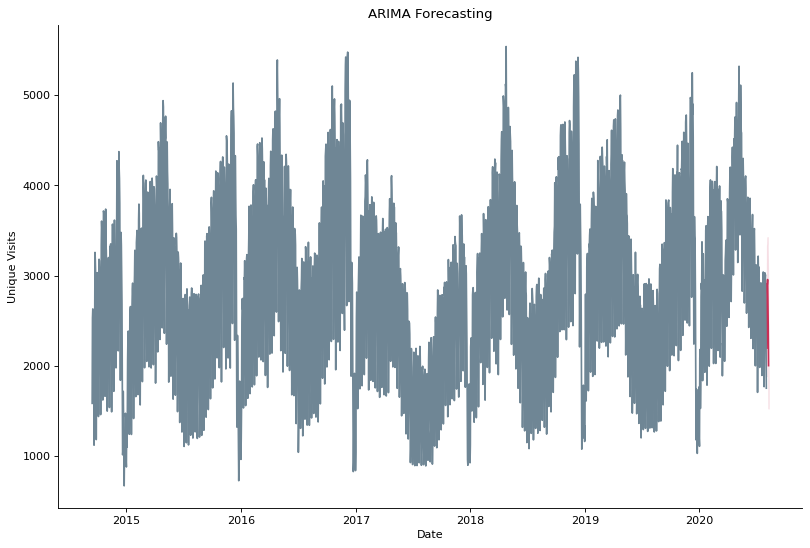

In [61]:
plot_forecast(web_visitors_unique.loc[:'2020-08-01'], forecast_values)

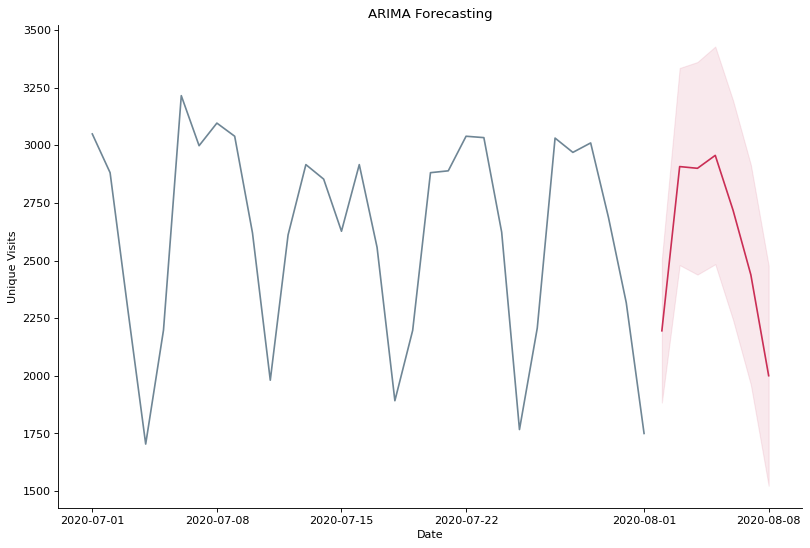

In [62]:
plot_forecast(web_visitors_unique.loc['2020-07-01':'2020-08-01'], forecast_values)